In [1]:
#fixes lib errors
import os
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32"

In [2]:
!pip install pymc3==3.11.2 arviz==0.11.2 theano-pymc bambi

In [3]:
#debug
import bambi
import arviz
import pymc3

print("Bambi version:", bambi.__version__)
print("ArviZ version:", arviz.__version__)
print("PyMC3 version:", pymc3.__version__)


Bambi version: 0.8.0
ArviZ version: 0.11.2
PyMC3 version: 3.11.2


In [4]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np

import bambi as bm
import arviz as az

from arviz import from_pymc3

In [5]:
# Load the dataset
data = pd.read_csv('/content/infection.csv')

print(data.head())
print(data.describe())
print(data.isnull().sum())

   InfctRsk   Age   Stay MedSchool         Region  Beds
0       4.1  55.7   7.13        No           west   279
1       1.6  58.2   8.82        No  north-central    80
2       2.7  56.9   8.34        No          south   107
3       5.6  53.7   8.95        No           west   147
4       5.7  56.5  11.20        No     north-east   180
         InfctRsk         Age        Stay        Beds
count  113.000000  113.000000  113.000000  113.000000
mean     4.354867   53.231858    9.648319  252.168142
std      1.340908    4.461607    1.911456  192.842687
min      1.300000   38.800000    6.700000   29.000000
25%      3.700000   50.900000    8.340000  106.000000
50%      4.400000   53.200000    9.420000  186.000000
75%      5.200000   56.200000   10.470000  312.000000
max      7.800000   65.900000   19.560000  835.000000
InfctRsk     0
Age          0
Stay         0
MedSchool    0
Region       0
Beds         0
dtype: int64


In [6]:
data = pd.read_csv('/content/infection.csv')

# Dummy
data = pd.get_dummies(data, columns=['Region'], drop_first=True)

#Clean Data
data['MedSchool'] = data['MedSchool'].map({'Yes': 1, 'No': 0})

# Fit a linear regression model
X = data[['Age', 'Stay', 'MedSchool', 'Beds', 'Region_north-east', 'Region_south', 'Region_west']]
X = sm.add_constant(X)
y = data['InfctRsk']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               InfctRsk   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     8.520
Date:                Fri, 27 Oct 2023   Prob (F-statistic):           3.10e-08
Time:                        05:34:45   Log-Likelihood:                -167.57
No. Observations:                 113   AIC:                             351.1
Df Residuals:                     105   BIC:                             373.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.9300      1.32

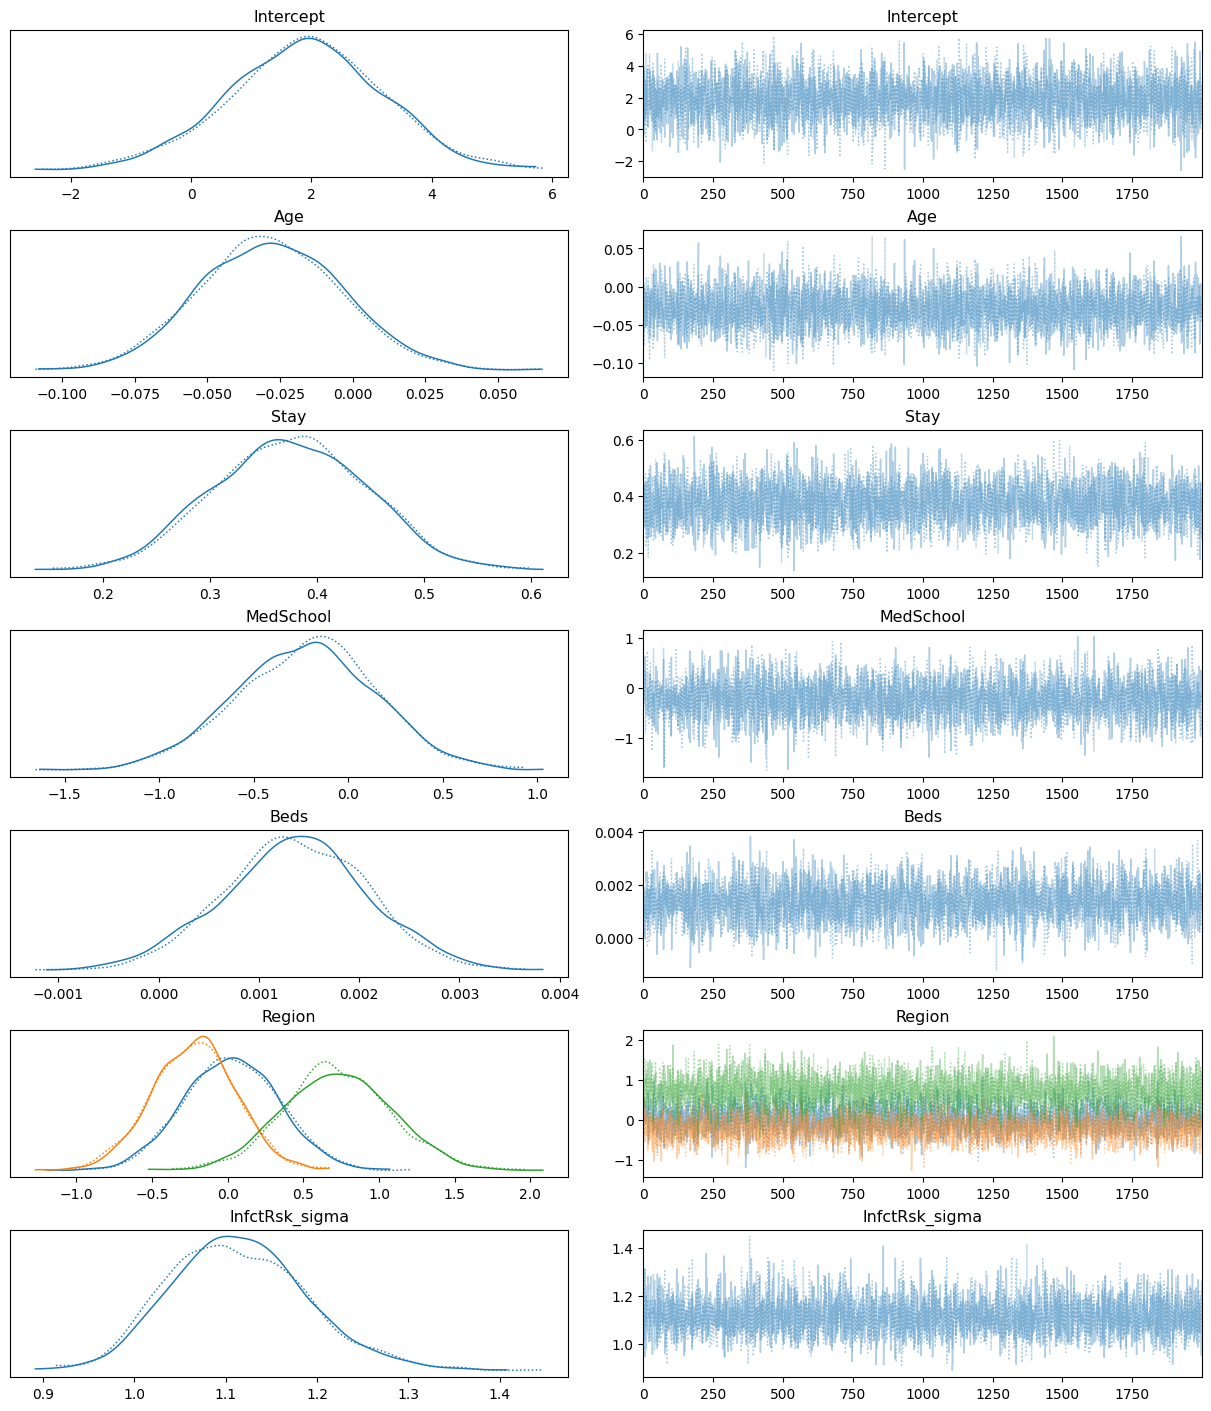

['north-central', 'north-east', 'south', 'west']


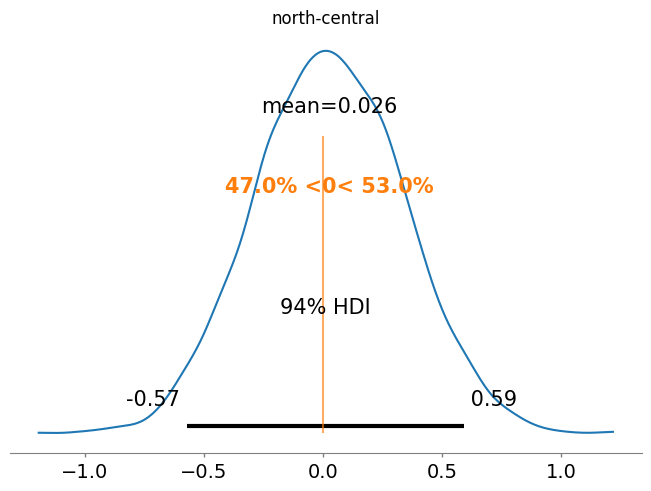

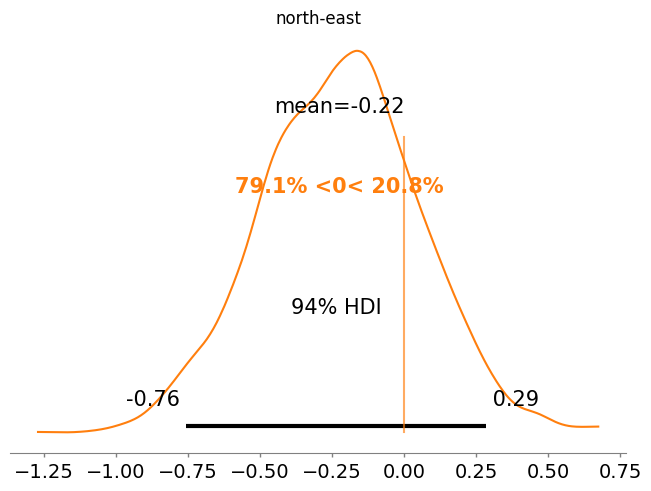

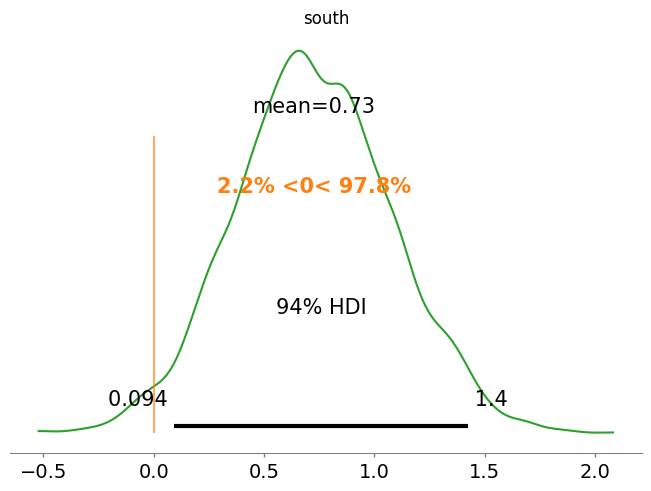

                 mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
Intercept       1.891  1.298    -0.697      4.409      0.018    0.014   
Age            -0.028  0.025    -0.077      0.019      0.000    0.000   
Stay            0.375  0.071     0.241      0.510      0.001    0.001   
MedSchool[0]   -0.225  0.377    -0.974      0.506      0.006    0.005   
Beds            0.001  0.001    -0.000      0.003      0.000    0.000   
Region[0]       0.026  0.312    -0.605      0.601      0.005    0.004   
Region[1]      -0.224  0.277    -0.792      0.291      0.005    0.004   
Region[2]       0.726  0.358     0.028      1.429      0.006    0.004   
InfctRsk_sigma  1.114  0.075     0.979      1.268      0.001    0.001   

                ess_bulk  ess_tail  r_hat  
Intercept         5488.0    2903.0    1.0  
Age               4732.0    3210.0    1.0  
Stay              3837.0    2933.0    1.0  
MedSchool[0]      4006.0    3025.0    1.0  
Beds              3920.0    3135.0    1.0  
Regio

In [7]:
# Data again to avoid a random errors
data = pd.read_csv('/content/infection.csv')
data['Region'] = data['Region'].astype('category')

# Bayesian
model = bm.Model('InfctRsk ~ Age + Stay + MedSchool + Beds + Region', data)
results = model.fit(draws=2000, chains=2)

# Plot
az.plot_trace(results)
plt.show()

# Regions
region_categories = list(data['Region'].cat.categories)
region_indices = list(range(len(region_categories)))

#debug
print(region_categories)
posterior_region_dim = results.posterior["Region"].shape[2]

# index fix
missing_index = None
if posterior_region_dim < len(region_categories):
    for index in range(len(region_categories)):
        try:
            results.posterior["Region"].isel(Region_dim=index)
        except IndexError:
            missing_index = index
            break

for index, region in zip(region_indices, region_categories):
    if index == missing_index:
        continue
    posterior_samples = results.posterior["Region"].isel(Region_dim=index).values
    az.plot_posterior(posterior_samples, ref_val=0, color="C"+str(index))
    plt.title(region)
    plt.show()



# Debug
print(az.summary(results, hdi_prob=0.95))
print(az.rhat(results))

missing_index = 0

for index, region in zip(region_indices, region_categories):
    if index == missing_index:
        # Debug
        print(f"{region} For Reference")
        continue
    posterior_samples = results.posterior["Region"].isel(Region_dim=index - (index > missing_index)).values
    prob_positive = (posterior_samples > 0).mean()
    prob_negative = 1 - prob_positive
    print(f"Prob {region} is a positive: {prob_positive*100:.2f}%")
    print(f"Prob {region} is a negative: {prob_negative*100:.2f}%")



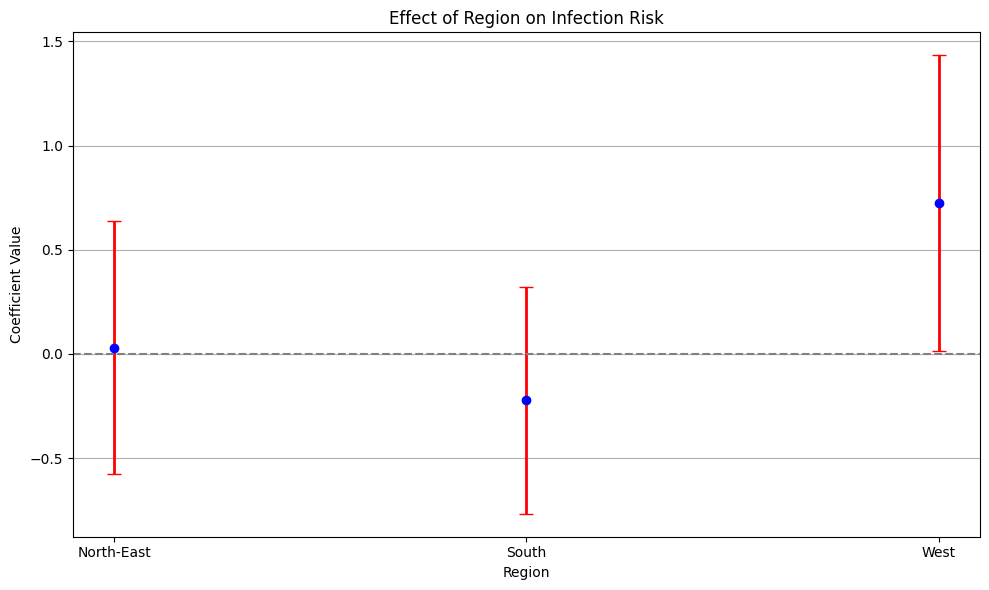

In [8]:
regions = ['North-East', 'South', 'West']
coefficients = [0.0299, -0.2220, 0.7237]
confidence_interval_lower = [-0.578, -0.767, 0.014]
confidence_interval_upper = [0.638, 0.323, 1.433]

plt.figure(figsize=(10, 6))
plt.errorbar(regions, coefficients, yerr=[(top - bot) / 2 for top, bot in zip(confidence_interval_upper, confidence_interval_lower)],fmt='o', capsize=5, color='blue', ecolor='red', elinewidth=2)
plt.axhline(0, color='grey', linestyle='--')
plt.title("Effect of Region on Infection Risk")
plt.ylabel("Coefficient Value")
plt.xlabel("Region")
plt.grid(axis='y')
plt.tight_layout()

plt.show()

# Discussion

1. It is imprtant to incorporate other variables because:

- Variables like Age, Stay, MedSchool, and Beds might be confounders in the relationship between Region and 'InfctRsk'. By not accounting for these variables, the estimated relationship between the region and infection risk might be biased.

- Incorporating relevant predictors can improve the model. Even if the main interest is in Region, other variables can provide important context and improve the overall fit of the model.

- In order to understand the factors influencing infection risk, it's important to consider all relevant variables, not just the primary variable of interest. Even if we focus on Region, understanding how other factors interact and influence the outcome can provide a more comprehensive understanding of data.


2. Bayesian vs. Traditional Regression:

- Traditional Regression:
  - Relies on the observed data to estimate parameters.
  - Provides point estimates and confidence intervals for params.
  - Do not incorporate prior beliefs or information about params.

  - Advantages:
    - Direct and often computationally simpler.

    - Limitations:
      - Cannot incorporate prior knowledge. Point estimates might not fully capture uncertainty.

- Bayesian Approach:

  - Combines prior beliefs or information with observed data to produce a posterior distribution for parameters.

  - Provides a full probability distribution for parameters.

- Allows update of beliefs as more data becomes available.


  - Advantages:
      - Incorporates prior knowledge, which can be beneficial when data is sparse or when there's strong prior information. Provides better uncertainty.

  - Limitations:
    - Need to specify prior distributions, which can be subjective. Often computationally more intensive.